# Mnist DataScience (Training Stage)

In [9]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))

http://172.30.0.50:46666
http://172.30.0.50:46667


In [1]:
import sys
import matplotlib.pyplot as plt
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowTrackerClient
from scanflow.client import ScanflowDeployerClient

# App folder
scanflow_path = "/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mnist/datascience")
app_name = "mnist"
team_name = "datascience"

# scanflow client
client = ScanflowClient(#scanflow_server_uri="http://172.30.0.50:46666",
                        verbose=True)

## 1. Develop scanflow application (local)

  1. develop component (requirement.txt, script.py)
  2. define scanflow application (Executor, Dependency, Workflow, Application)
  ```bash
     Application
        - List: Workflow(DAG)
                  - List: Executor
                  - List: Dependency
  ```
  
     For example:
     
  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - modeling_cnn1
         - modeling.py
         - req_modeling.txt
       - modeling_cnn2
         - modeling.py
         - req_modeling.txt
       - checker
         - checker.py
         - req_checker.txt
```


In [2]:
executor1 = client.ScanflowExecutor(name='load-data', 
                      mainfile='loaddata.py',
                      parameters={'app_name': app_name,
                                  'team_name': 'data'})

executor2 = client.ScanflowExecutor(name='modeling-cnn1', 
                      mainfile='modeling.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs': 1,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 
                                  'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
                                  'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
                                  'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt')

#20
executor3 = client.ScanflowExecutor(name='modeling-cnn2', 
                      mainfile='modeling.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs': 2,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy',
                                  'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
                                  'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
                                  'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt',
                      base_image='modeling-cnn1')

#50
executor4 = client.ScanflowExecutor(name='checker', 
                      mainfile='checker.py',
                      parameters={'model_name': 'mnist_detector',
                                  'epochs': 1,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy'},
                      requirements='req_checker.txt')



dependency1 = client.ScanflowDependency(dependee='load-data',
                                    depender='modeling-cnn1')

dependency2 = client.ScanflowDependency(dependee='load-data',
                                    depender='modeling-cnn2')

dependency3 = client.ScanflowDependency(dependee='load-data',
                                    depender='checker')

##workflow1 mnist-wf
## -- load_data
##       -- modeling_cnn
##       -- modeling_cnn1
workflow1 = client.ScanflowWorkflow(name='mnist-wf', 
                     executors=[executor1, executor2, executor3],
                     dependencies=[dependency1, dependency2],
                     output_dir = "/workflow")
##workflow2 mnist-checker-wf
## -- load_data
##    -- checker
workflow2 = client.ScanflowWorkflow(name='mnist-checker-wf', 
                     executors=[executor1, executor4],
                     dependencies=[dependency3],
                     output_dir = "/workflow")


app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=[workflow1, workflow2])
              

In [3]:
dic = app.to_dict()

22-May-21 19:05:30 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': None}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': None}, {'name': 'modeling-cnn2', 'mainfile': 'modeling.py', 'parameters': {'

  
## 2. Build scanflow application (local build)
   
  1. build images for Executor -> save to image registry



In [4]:
build_app = client.build_ScanflowApplication(app = app, trackerPort=46668)

22-May-21 19:05:31 -  INFO - Building image 172.30.0.49:5000/load-data
22-May-21 19:05:31 -  INFO - Building image 172.30.0.49:5000/modeling-cnn1
22-May-21 19:05:31 -  INFO - Building image 172.30.0.49:5000/modeling-cnn2
22-May-21 19:05:31 -  INFO - Building image 172.30.0.49:5000/load-data
22-May-21 19:05:31 -  INFO - Building image 172.30.0.49:5000/checker


In [5]:
#build_app.to_dict()

## 3. Deploy scanflow application (user_type=incluster)
  
  1. deploy scanflow application
        - create namespace
        - deploy scanflow-local-tracker (k8s)
        - run workflows (argo)
            - run workflow1 to train model_cnn
            - run workflow2 to train checker
            


In [6]:
deployerClient = ScanflowDeployerClient(user_type="incluster",
                                        deployer="argo",
                                        k8s_config_file="/gpfs/bsc_home/xpliu/.kube/config")

In [7]:
await deployerClient.create_environment(app=build_app)

22-May-21 18:29:55 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest'}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/modeling-cnn1:latest'}, {'n

True

In [8]:
await deployerClient.run_app(app=build_app)

22-May-21 19:00:41 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest'}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/modeling-cnn1:latest'}, {'n

TypeError: 'coroutine' object is not subscriptable

In [ ]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/mnist-wf.PNG", width=1200, height=400)

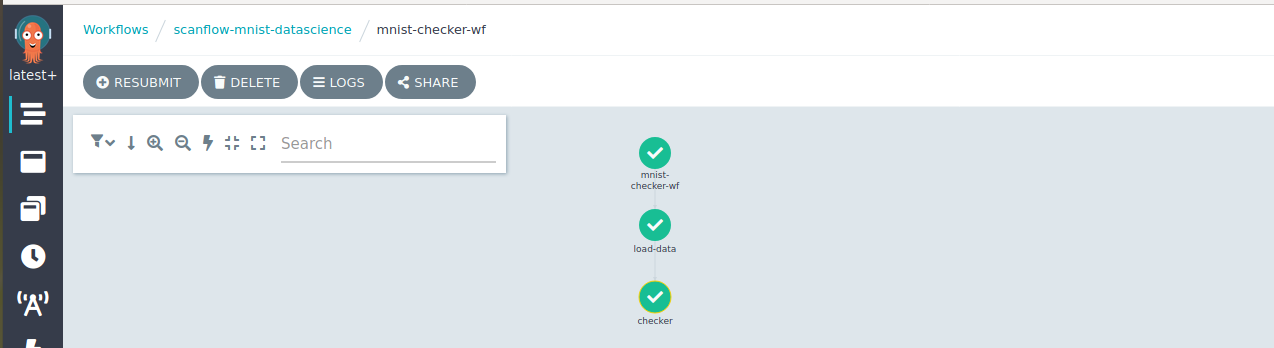

In [8]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/mnist-checker-wf.PNG", width=1200, height=400)

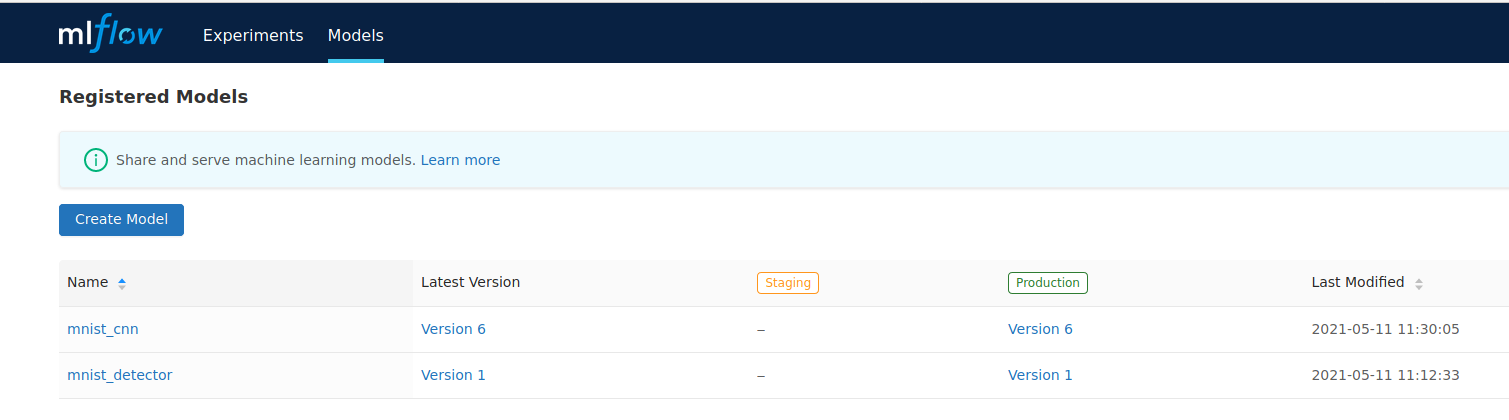

In [27]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/model-registry.PNG", width=1200, height=400)

## --------------------Team to Evaluate the model-------(if training stage is finished)-------------

## 4. Submit scanflow app metadata

  scanflowapp metadata
  ```bash
   datascience
     - workflows
        - mnist-check-wf.json
        - mnist-wf.json
     - mnist.json
  ```

In [9]:
client.submit_ScanflowApplication(build_app)

21-May-21 15:48:17 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest'}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/modeling-cnn1:latest'}, {'n

TypeError: string indices must be integers

## 4. Submit prepared production model 

 scanflow model
  1. submit mnist-checker model (e.g., mnist_detector)
  2. submit mnist model (e.g., mnist_cnn)

In [7]:
trackerClient = ScanflowTrackerClient(scanflow_tracker_local_uri="http://172.30.0.50:46668",
                        verbose=True)

In [8]:
trackerClient.save_app_model(app_name=app_name,
                            team_name=team_name,
                            model_name="mnist_cnn")

11-May-21 16:53:18 -  INFO - Found credentials in environment variables.
/gpfs/bsc_home/xpliu/anaconda3/lib/python3.8/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  stdout_func(
/gpfs/bsc_home/xpliu/anaconda3/lib/python3.8/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(
Registered model 'mnist_cnn' already exists. Creating a new version of this model...
2021/05/11 16:53:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_cnn, version 3
Created version '3' of model 'mnist_cnn'.
11-May-21 16:53:23 -  INFO - unsupported model_type {model_type}


In [8]:
trackerClient.save_app_model(app_name=app_name,
                            team_name=team_name,
                            model_name="mnist_detector")

18-May-21 17:42:22 -  INFO - Found credentials in environment variables.
2021/05/18 17:42:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_detector, version 6


## 5. save all artifacts 



 scanflowapp artifacts

  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - modeling_cnn1
         - modeling.py
         - req_modeling.txt
       - modeling_cnn2
         - modeling.py
         - req_modeling.txt
       - checker
         - checker.py
         - req_checker.txt
```


In [22]:
trackerClient.save_app_artifacts(app_name=app_name, 
                                team_name=team_name, 
                                app_dir=app_dir)

03-May-21 09:04:08 -  INFO - Connecting tracking server uri: http://172.30.0.50:46667
03-May-21 09:04:08 -  INFO - save app in /gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience to artifact uri: s3://scanflow/1/eafb6072a45a4c459859d4a45ab599a2/artifacts



  
## 6. Clean environment (scanflow-server)
  
  1. clean training workflow, delete namespace
  

In [7]:
await deployerClient.delete_app(app=build_app)

22-May-21 19:05:45 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest'}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/modeling-cnn1:latest'}, {'n

TypeError: 'coroutine' object is not subscriptable

In [8]:
await deployerClient.clean_environment(app=build_app)

22-May-21 16:32:04 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load-data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest'}, {'name': 'modeling-cnn1', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/modeling-cnn1:latest'}, {'n

True

In [9]:
client.draw_ScanflowApplication(scanflowapp=build_app)

NameError: name 'ApplicationGraph' is not defined